# XGBoost

* Performs xgboost on training data. 
* Iterates over parameters with cross validation
* Currently ignoring date parameters due to large number of factors. Waiting for preprocessing steps to improve. 
* Warning: takes a long time to cross validate

In [1]:
# Libraries
library(xgboost)
library(dplyr)
library(Matrix)
library(data.table)
library(Ckmeans.1d.dp)
library(e1071)
library(caret)

# Set Seed
set.seed(1066)


Attaching package: 'dplyr'

The following object is masked from 'package:xgboost':

    slice

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, last

Loading required package: lattice
Loading required package: ggplot2


** Currently remove date features because of large number of factors **  

In [2]:
# Read data
# remove id and date_first_booking as they are not relevant
# CURRENTLY REMOVES DATE PARAMETERS AS WELL
dat_raw <- readRDS("../Data/users.RDS") %>%
    na.omit()

dat <- dat_raw %>%
    select(-c(id,set)) %>%
    select(-c(date_account_created, first_browser)) %>% ## Removing more complex factors
    data.table(keep.rownames = F)

In [3]:
# One-hot encoding  
# https://cran.r-project.org/web/packages/xgboost/vignettes/discoverYourData.html
sparse_dat <- sparse.model.matrix(country_destination ~ . -1, data = dat)

# Find the training set
sparse_tr <- sparse_dat[dat_raw$set == "train",]
tr <- dat[dat_raw$set == "train",]

In [4]:
# Parameter search using Cross validation
# http://stats.stackexchange.com/questions/171043/how-to-tune-hyperparameters-of-xgboost-trees
# Currently using low number of rounds to test

# set up the cross-validated hyper-parameter search
xgb_grid_1 = expand.grid(
    nrounds = 10,                    # Iterations building each XGB model (100)
    max_depth = c(2, 3, 4, 5),       # Maximum tree depth c(2, 4, 6, 8, 10)
    eta = c(0.01, 0.005, 0.001),     # Learning rate c(0.01, 0.001, 0.0001)
    gamma = 1,                       # Min loss reduction required to make a partition on leaf node [0:inf]
    colsample_bytree = 0.3,          # proportion of features used in each tree c(0.3, 0.5, 0.7)
    min_child_weight = 1
)

# trainControl creates settings for caret::train
xgb_trcontrol_1 = trainControl(
    method = "cv",          # Cross validation
    number = 3,             # number of folds (5)
    verboseIter = TRUE,
    returnData = FALSE,
    returnResamp = "all",   # How many summary stats to save # save losses across all models
    allowParallel = TRUE
)

In [5]:
# Train XGboost
# "Kappa" metric used for evaluation
xgb_train_1 = train(
    x = sparse_tr,
    y = tr$country_destination,
    trControl = xgb_trcontrol_1,
    tuneGrid = xgb_grid_1,
    method = "xgbTree", 
    metric = "Kappa"
)

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



+ Fold1: eta=0.001, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.001, max_depth=3, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=3, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.001, max_depth=4, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=4, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.001, max_depth=5, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=5, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.005, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.005, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.005, max_depth=3, gamma=1

In [6]:
saveRDS(xgb_train_1, "./Models/xgb_model.RDS")

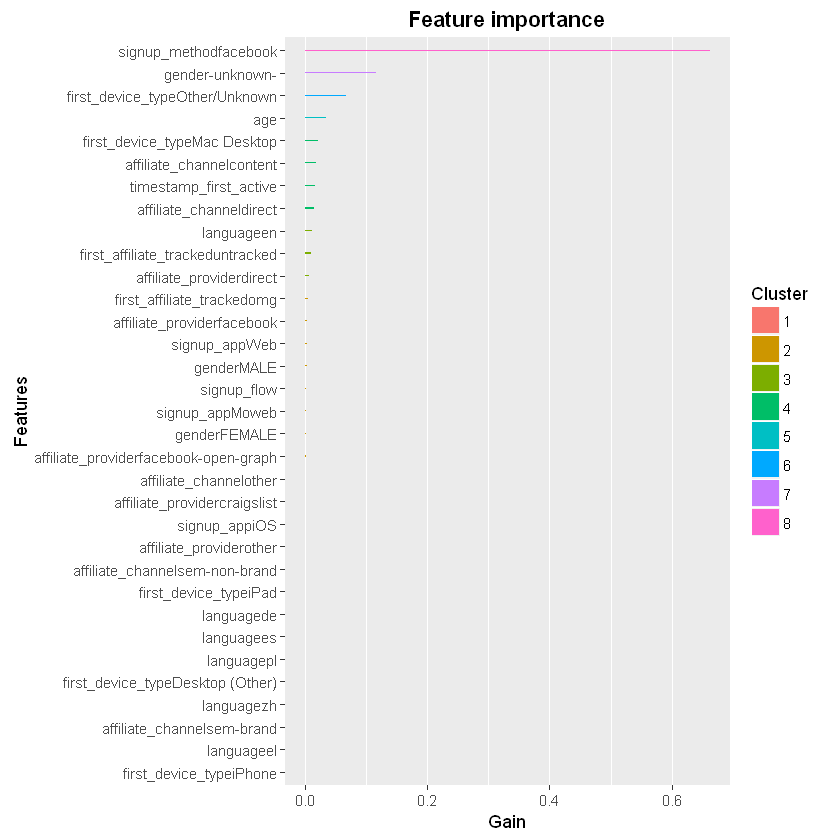

In [7]:
# Evaluating importance of features to the model
importance <- xgb.importance(sparse_tr@Dimnames[[2]], 
                             model = xgb_train_1$finalModel, 
                             data = sparse_tr, 
                             label = as.numeric(tr$country_destination)
                            )
xgb.plot.importance(importance_matrix = importance)

In [8]:
str(xgb_train_1$finalModel)
xgb_train_1$results$Kappa

List of 6
 $ handle     :Class 'xgb.Booster.handle' <externalptr> 
 $ raw        : raw [1:43340] 00 00 00 3f ...
 $ xNames     : chr [1:77] "timestamp_first_active" "gender-unknown-" "genderFEMALE" "genderMALE" ...
 $ problemType: chr "Classification"
 $ tuneValue  :'data.frame':	1 obs. of  6 variables:
  ..$ nrounds         : num 10
  ..$ max_depth       : num 2
  ..$ eta             : num 0.01
  ..$ gamma           : num 1
  ..$ colsample_bytree: num 0.3
  ..$ min_child_weight: num 1
 $ obsLevels  : chr [1:12] "AU" "CA" "DE" "ES" ...
 - attr(*, "class")= chr "xgb.Booster"


[1] 0.1550579 0.1657785 0.1898924 0.1226833 0.1413039 0.1367313 0.1589097
 [8] 0.1575720 0.1639575 0.1604574 0.1609097 0.1573084

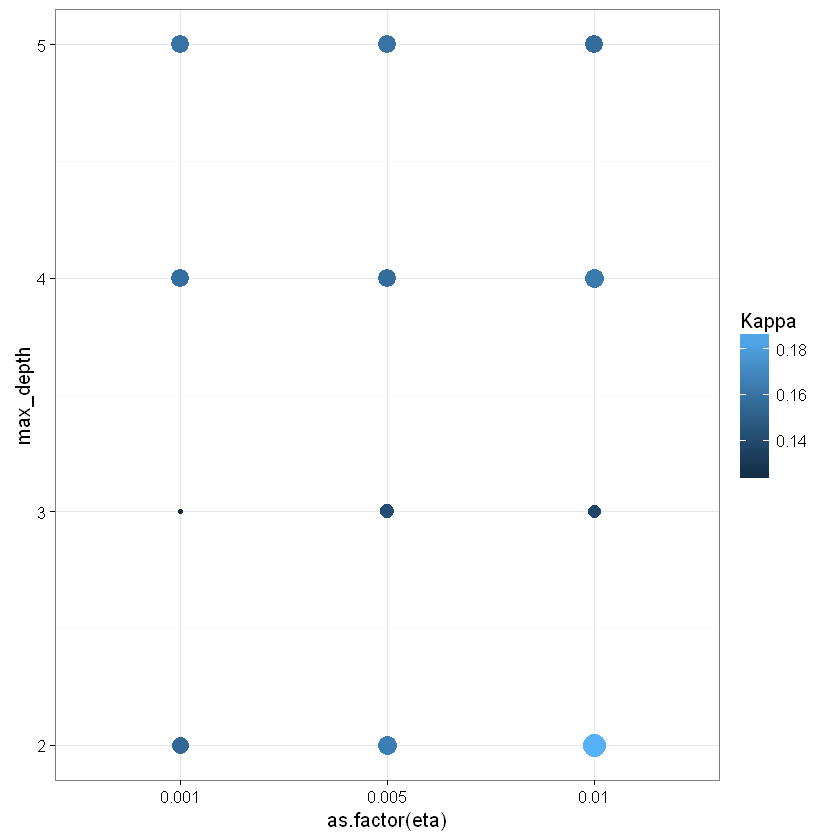

In [9]:
# scatter plot of the Kappa against max_depth and eta
ggplot(xgb_train_1$results, aes(x = as.factor(eta), y = max_depth, size = Kappa, color = Kappa)) + 
    geom_point() + 
    theme_bw() + 
    scale_size_continuous(guide = "none")

# Predictions
We use the "predictions" function to evaluate our model on both the training set and set set. We see from the below that the probabilities lead to NDF and US always being predicted. The accuracy at this point is also quite low. 

In [10]:
source("Predictions.R")
pred <- predictions(xgb_train_1$finalModel, sparse_dat, dat_raw$set, dat$country_destination)

pred$pred_tr %>% table()
pred$acc_tr

pred$pred_ts %>% table()
pred$acc_ts

 logi [1:158681] TRUE FALSE TRUE TRUE FALSE TRUE ...
NULL
 Factor w/ 12 levels "AU","CA","DE",..: 8 10 12 12 12 12 8 8 2 12 ...
NULL


.
  NDF    US 
62942 31043 

[1] 0.5272224

.
  NDF    US 
21074 10402 

[1] 0.525162

## Submission
https://www.kaggle.com/indradenbakker/airbnb-recruiting-new-user-bookings/rscript-0-86547/discussion  
As per the example script above this submission file currently just takes the top 5 predictions in order as its submission file.

In [34]:
# Generate predictions on competition test set. 
#pred <- predict(xgb_train_1, sparse_test)
# compare prediction to results
source("Generate_submission.R")
sparse_test <- sparse_dat[dat_raw$set == "test_external",]
id <- dat_raw[dat_raw$set == "test_external", "id"]
final <- submission(xgb_train_1$finalModel, sparse_test, id, "xgb_1")

In [32]:
str(final)

List of 2
 $ df  :'data.frame':	33220 obs. of  6 variables:
  ..$ V1: Factor w/ 2 levels "NDF","US": 1 1 1 2 1 1 2 2 1 1 ...
  .. ..- attr(*, "names")= chr [1:33220] "V1" "V2" "V3" "V4" ...
  ..$ V2: Factor w/ 2 levels "NDF","US": 2 2 2 1 2 2 1 1 2 2 ...
  .. ..- attr(*, "names")= chr [1:33220] "V1" "V2" "V3" "V4" ...
  ..$ V3: Factor w/ 1 level "other": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:33220] "V1" "V2" "V3" "V4" ...
  ..$ V4: Factor w/ 2 levels "ES","FR": 2 2 2 2 2 2 2 2 2 2 ...
  .. ..- attr(*, "names")= chr [1:33220] "V1" "V2" "V3" "V4" ...
  ..$ V5: Factor w/ 5 levels "DE","ES","FR",..: 5 5 5 5 4 5 5 5 5 5 ...
  .. ..- attr(*, "names")= chr [1:33220] "V1" "V2" "V3" "V4" ...
  ..$ id: Factor w/ 275547 levels "00023iyk9l","0005ytdols",..: 223495 263505 242626 241024 245882 238862 258680 244657 233646 260784 ...
 $ file:'data.frame':	166100 obs. of  2 variables:
  ..$ id     : Factor w/ 33220 levels "0031awlkjq","00378ocvlh",..: 5355 5355 5355 5355 5355 26766 